# Adjoint plugin

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FAdjoint.ipynb).

In [1]:
from typing import List

import numpy as np
import jax.numpy as jnp
import matplotlib.pylab as plt
from jax import grad, value_and_grad

import sys; sys.path.append('../../../tidy3d')
import tidy3d as td
import tidy3d.web as web

from tidy3d.plugins.adjoint.components import JaxSimulation, JaxBox, JaxMedium, JaxStructure, JaxSimulationData
from tidy3d.plugins.adjoint.web import run

INFO:rich:Using client version: 1.8.0


In [2]:
# wavelength and frequency
wavelength = 1.0
freq0 = td.C_0 / wavelength
k0 = 2 * np.pi * freq0 / td.C_0

# resolution control
dl = 0.02

# space between boxes and PML
buffer = 1.5 * wavelength

# initial size of boxes and waveguide
lx0, ly0, lz0 = 1., 1., 8 * dl
wg_width = .7

# position of source and monitor (constant for all)
source_x = -lx0 - 1
meas_x = lx0 + 1

# total size
Lx = 2 * lx0 + 2 * buffer
Ly = 2 * ly0 + 2 * buffer
Lz = lz0 + 2 * buffer

# simulation parameters
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

# permittivity at each quadrant of box
quadrants = [x + y for x in "+-" for y in "+-"]
permittivities = [2.0, 2.5, 3.0, 3.5]
grid_spec = td.GridSpec.auto(wavelength=wavelength, min_steps_per_wvl=(wavelength/dl/np.sqrt(max(permittivities))))
# grid_spec = td.GridSpec.uniform(dl=dl)

wg_eps = 2.75

# frequency width and run time
freqw = freq0 / 10
run_time = 10 / freqw

# polarization of initial source
pol = "Ey"

# monitor for plotting
monitor_field = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="field_pattern",
)

# default box center and sizes
center = 0 * np.array([-1e-5, -1e-5, -1e-5])

size = np.array([lx0, ly0, lz0])
ds = -0.0

In [3]:
waveguide = td.Structure(
    geometry=td.Box(size=(td.inf, wg_width, lz0)),
    medium=td.Medium(permittivity=wg_eps)
)

mode_size = (0,4,3)

# source seeding the simulation
forward_source = td.ModeSource(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0/10),
        center=[source_x, 0, 0],
        size=mode_size,
        mode_index=0,
        direction="+"
    )

# we'll refer to the measurement monitor by this name often
measurement_monitor_name = 'measurement'

num_modes = 3

# monitor where we compute the objective function from
measurement_monitor = td.ModeMonitor(
    center=[meas_x, 0, 0],
    size=mode_size,
    freqs=[freq0],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    name=measurement_monitor_name,
)

In [4]:
def make_input_structures(*permittivities) -> List[JaxStructure]:

    eps_boxes = {quad: eps for (quad, eps) in zip(quadrants, permittivities)}
    boxes_quad = []
    for i, (quad, eps) in enumerate(eps_boxes.items()):

        x, y = quad
        xsign = 1 if x == "+" else -1
        ysign = 1 if y == "+" else -1

        center_quad = center.tolist()
        center_quad[0] += xsign * lx0 / 2
        center_quad[1] += ysign * ly0 / 2
        size_quad = size.tolist()
        size_quad[0] += i * ds
        size_quad[1] += i * ds

        box_quad = JaxStructure(
            geometry=JaxBox(center=center_quad, size=size_quad),
            medium=JaxMedium(permittivity=eps),
            name=quad,
        )
        boxes_quad.append(box_quad)
    return boxes_quad

In [5]:
def make_sim(*permittivities) -> JaxSimulation:
    """Make a simulation using a sequence of 4 permittivity values."""
    
    input_structures = make_input_structures(*permittivities)
    return JaxSimulation(
        size=[Lx, Ly, Lz],
        grid_spec=grid_spec,
        structures=[waveguide],
        input_structures=input_structures,
        sources=[forward_source],
        monitors=[monitor_field],
        output_monitors=[measurement_monitor],
        run_time=run_time,
        subpixel=False,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        shutoff=1e-8,
        courant=0.9,
    )

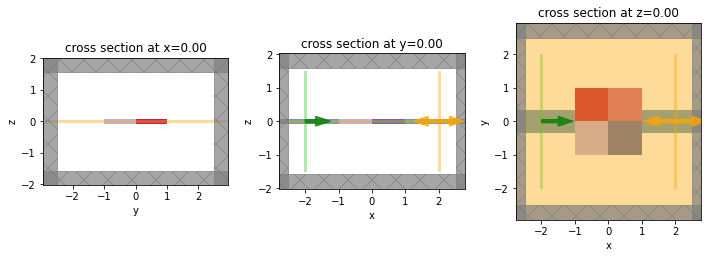

In [6]:
sim_base = make_sim(*permittivities)

f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(10, 5))

for dim, ax in zip('xyz', axes):
    sim_base.to_simulation()[0].plot(**{dim:0}, ax=ax)

plt.show()

In [7]:
def measure_power(sim_data: JaxSimulationData) -> float:
    """Power in the 0th order mode."""
    output_amps = sim_data.output_data[0].amps
    amp = output_amps.sel(direction="+", f=freq0, mode_index=0)
    return jnp.sum(jnp.abs(amp)**2)

In [8]:
def J(*permittivities) -> float:
    """Objective function, construct simulation, run it using adjoint plugin, and return power in mode_index=0."""
    sim = make_sim(*permittivities)
    sim_data = run(sim, task_name="4_boxes")
    power_mode_0 = measure_power(sim_data)
    return power_mode_0

In [9]:
# power = J(*permittivities)
# print(f"measured power = {power:.2f}")

In [10]:
dJ_fn = grad(J, argnums=(0,1,2,3))

In [11]:
de1, de2, de3, de4 = grad_eps = dJ_fn(*permittivities)

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━ 93.5% • 5.0/5.3 MB • 442.1 kB/s • 0:00:01

INFO:rich:loading SimulationData from simulation_data.hdf5


In [12]:
grad_eps = np.array(grad_eps) / k0**3
grad_grad_eps_normalized = grad_eps / np.linalg.norm(grad_eps)
print(f"Jax gradient: {grad_grad_eps_normalized}")

Jax gradient: [ 0.6080506  -0.37160957  0.39885262 -0.57714593]


Numerical Gradient (from Adjoint.ipynb): [0.64185051 -0.28992203  0.37546415 -0.60249465]

In [13]:
grad_jax = np.array(grad_eps).copy()

## Numerical Derivative

In [14]:
# step size
delta = 1e-3

jax_sim_0 = make_sim(*permittivities)
sims_batch_numerical = {}
jax_info_dict = {}

for i, eps_i in enumerate(permittivities):

    for sign in (+1, -1):
        input_structures_perturbed = list(jax_sim_0.input_structures)
        structure_i = input_structures_perturbed[i]
        deps = sign * delta
        new_medium = structure_i.medium.copy(update=dict(permittivity=structure_i.medium.permittivity + deps))
        new_structure = structure_i.copy(update=dict(medium=new_medium))
        input_structures_perturbed[i] = new_structure
        jax_sim_perturbed = jax_sim_0.copy(update=dict(input_structures=input_structures_perturbed))
        sim_perturbed, jax_info = jax_sim_perturbed.to_simulation()
        task_name = f'numerical_{i}_{sign}'
        sims_batch_numerical[task_name] = sim_perturbed
        jax_info_dict[task_name] = jax_info

# run a batch of each of these 8 calculations at once
batch_data = web.Batch(simulations=sims_batch_numerical).run(path_dir='data')

numerical_0_1: status = postprocess ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━  71% -:--:--
numerical_0_-1: status = success    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
numerical_1_1: status = success     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
numerical_1_-1: status = success    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
numerical_2_1: status = success     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
numerical_2_-1: status = running    ━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━  57% -:--:--
numerical_3_1: status = success     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
numerical_3_-1: status = success    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

[21:03:27] Batch complete.                                                                         ]8;id=565315;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=628159;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#375\375]8;;\

In [15]:
# power_info[i] stores the [-, +] perturbations of permittivities[i]
power_info = [[None, None] for _ in range(len(permittivities))]

for task_name, sim_data_delta in batch_data.items():
    jax_info = jax_info_dict[task_name]
    jax_sim_data_delta = JaxSimulationData.from_sim_data(sim_data_delta, jax_info)
    
    # compute the objective function f(x)
    power = measure_power(jax_sim_data_delta)
    _, i, sign = task_name.split('_')
    sign_index = 0 if float(sign) < 0 else 1
    power_info[int(i)][sign_index] = power

grad_num = []
for power_minus, power_plus in power_info:
    grad_num.append((power_plus - power_minus) / 2 / delta)

# grad_num = np.array([ 0.22795795, -0.09849667,  0.12129544, -0.22104381])

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺ 98.5% • 2.6/2.7 MB • 476.4 kB/s • 0:00:01

INFO:rich:loading SimulationData from data/3e06416f-b756-443d-b62a-cae62be3e147.hdf5


In [16]:
grad_num = np.array(grad_num)
print(grad_num)

[ 0.24239717 -0.14905632  0.2785027  -0.25185943]


In [17]:
rms_error = np.linalg.norm(grad_num - grad_jax) / np.linalg.norm(grad_num)

print('numerical (unnormalized): ', grad_num)
print('using jax (unnormalized): ', grad_jax)
print(f'norm(diff) / norm(numerical): {(rms_error * 100):.3f} %')

numerical (unnormalized):  [ 0.24239717 -0.14905632  0.2785027  -0.25185943]
using jax (unnormalized):  [ 0.2132835  -0.13034801  0.13990395 -0.2024432 ]
norm(diff) / norm(numerical): 32.084 %


In [18]:
grad_num_normalized = grad_num / np.linalg.norm(grad_num)
grad_jax_normalized = grad_jax / np.linalg.norm(grad_jax)
rms_error_normalized = np.linalg.norm(grad_num_normalized - grad_jax_normalized) / np.linalg.norm(grad_num_normalized)

print('numerical (normalized): ', grad_num_normalized)
print('using jax (normalized): ', grad_jax_normalized)
print(f'norm(diff) / norm(numerical): {(rms_error_normalized * 100):.3f} %')

numerical (normalized):  [ 0.51449287 -0.31637502  0.5911276  -0.53457665]
using jax (normalized):  [ 0.6080506  -0.37160957  0.39885262 -0.57714593]
norm(diff) / norm(numerical): 22.491 %


In [19]:
print(f'- dl={dl:.2f}: norm(diff) / norm(numerical): {(rms_error_normalized * 100):.3f} %')

- dl=0.02: norm(diff) / norm(numerical): 22.491 %
